# Method1 SVD+Huffman

### Code

#### Import the EDF file
Installation: https://mne.tools/dev/install/mne_python.html

Function description: https://mne.tools/dev/generated/mne.io.read_raw_edf.html

#### #Convert the edf file into csv and reload the csv file

If we just use raw_data[0], just as the we mentioned above, this step will not be needed anymore

In [1]:
import numpy as np

In [2]:
import pandas as pd
acc = pd.read_csv('ACC.csv')

In [3]:
acc

,1563898771.000000,1563898771.000000,1563898771.000000.1
0,32.0,32.0,32.0
1,-5.0,-62.0,5.0
2,-5.0,-63.0,5.0
3,-5.0,-63.0,5.0
4,-5.0,-62.0,5.0
...,...,...,...
72644,1.0,21.0,-67.0
72645,8.0,14.0,-59.0
72646,8.0,12.0,-57.0
72647,4.0,21.0,-64.0


In [4]:
acc = acc.iloc[1:]
acc.columns = ['column1','column2','column3']
acc

,column1,column2,column3
1,-5.0,-62.0,5.0
2,-5.0,-63.0,5.0
3,-5.0,-63.0,5.0
4,-5.0,-62.0,5.0
5,-5.0,-63.0,5.0
...,...,...,...
72644,1.0,21.0,-67.0
72645,8.0,14.0,-59.0
72646,8.0,12.0,-57.0
72647,4.0,21.0,-64.0


In [5]:
np.savetxt('acc.txt',acc)

#### Plot the signal to explore the data

In [6]:
sampling_freq = 1/32  #This is the sampling frequency
N = len(acc)  #The number of point
N

72648

In [7]:
index = np.linspace(0, round((N-1)*sampling_freq,4), N) #Set the time sequence for the signal
index

array([0.00000000e+00, 3.12500007e-02, 6.25000014e-02, ...,
       2.27015630e+03, 2.27018755e+03, 2.27021880e+03])

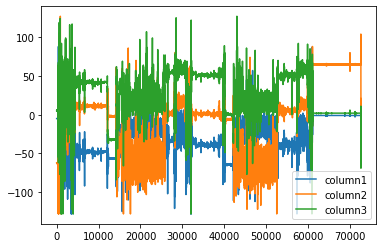

In [8]:
acc.plot()

In [9]:
acc_c1 = acc["column1"]
acc_c2 = acc["column2"]
acc_c3 = acc["column3"]
acc_array_c1 = acc_c1.to_numpy() #save the data into an ndarray
acc_array_c2 = acc_c2.to_numpy()
acc_array_c3 = acc_c3.to_numpy()
acc_array_c1.shape

(72648,)

#### Truncate the signal 
Get rid of the first 3mins and last 5mins

In [10]:
acc_array_c1 = acc_array_c1[0:62000]  # Remove the signal in first 3minutes and last 5minutes
acc_array_c2 = acc_array_c2[0:62000]
acc_array_c3 = acc_array_c3[0:62000]

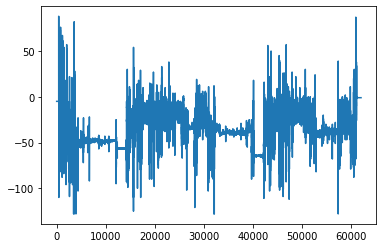

In [11]:
import matplotlib.pyplot as plt
plt.plot(acc_array_c1)

In [12]:
acc_array_c1.size

62000

In [13]:
sampling_freq = 1/32
N = acc_array_c1.size

In [14]:
index = np.linspace(0, round((N-1)*sampling_freq,4), N)
index

array([0.00000000e+00, 3.12500008e-02, 6.25000016e-02, ...,
       1.93740630e+03, 1.93743755e+03, 1.93746880e+03])

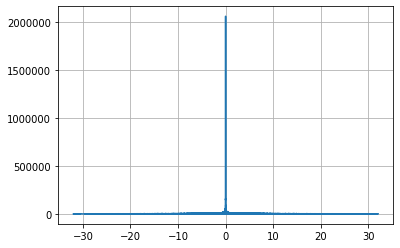

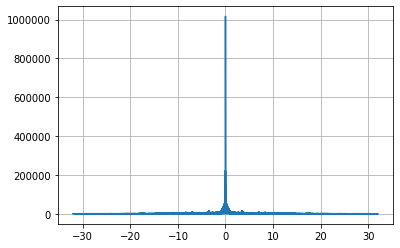

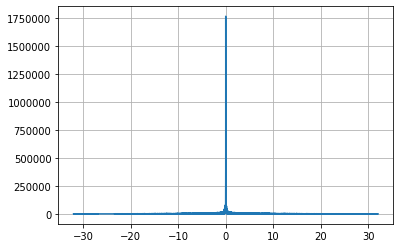

In [15]:
from scipy.fft import fft,fftshift
# Number of sample points

y1 = acc_array_c1
y2 = acc_array_c2
y3 = acc_array_c3
yf1 = fft(y1)
yf2 = fft(y2)
yf3 = fft(y3)
yf1 = fftshift(yf1)
yf2 = fftshift(yf2)
yf3 = fftshift(yf3)
xf = np.linspace(-1/sampling_freq, 1/sampling_freq, N)
import matplotlib.pyplot as plt
plt.plot(xf, np.abs(yf1))
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()
plt.plot(xf, np.abs(yf2))
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()
plt.plot(xf, np.abs(yf3))
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

#### Ideal filter

The result shows that the ideal filter will introduce some baseline drift, so we plan to use butterworth filter later

#### Butterworth Band pass Filter

In [16]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

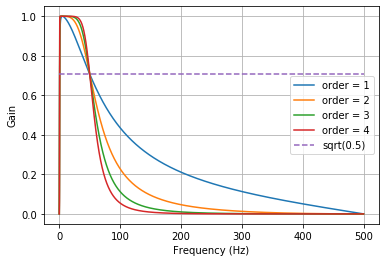

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

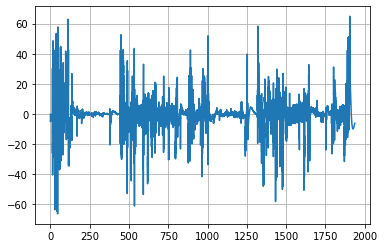

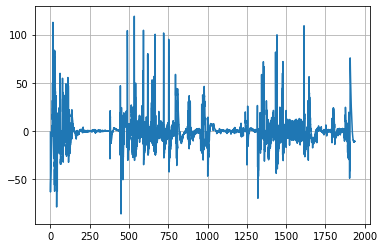

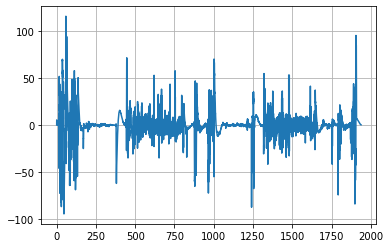

In [18]:
y1 = butter_bandpass_filter(acc_array_c1, lowcut, highcut, fs, order=2)
plt.plot(index, y1, label='Filtered signal (Hz)')
plt.grid(True)
plt.show()
y2 = butter_bandpass_filter(acc_array_c2, lowcut, highcut, fs, order=2)
plt.plot(index, y2, label='Filtered signal (Hz)')
plt.grid(True)
plt.show()
y3 = butter_bandpass_filter(acc_array_c3, lowcut, highcut, fs, order=2)
plt.plot(index, y3, label='Filtered signal (Hz)')
plt.grid(True)
plt.show()

From the original signal, we could see that the T wave is much higher than P wave. Butterworth filter with order=2 could show this feature sucessfully. However, with order=3 and order=4, the difference between T wave and P wave are decreased.

#### Resampling

For ACC, it's not so necessary to resample the signal because the sample frequency of the original signal is 32Hz. But in order to SVD, we need to approximate the signal into a squared number

In [19]:
N

62000

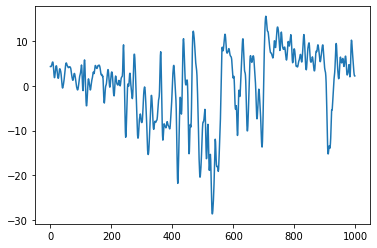

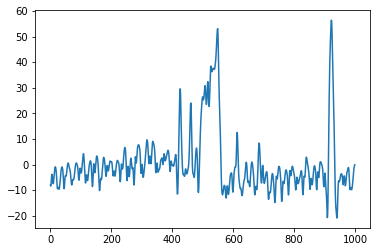

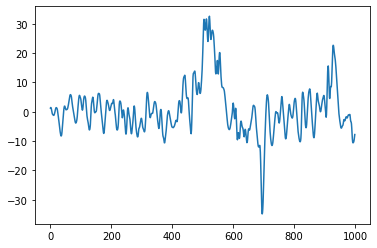

In [20]:
from scipy import signal
#y = butter_bandpass_filter(ppg_array, lowcut, highcut, fs, order=2)
resampled_signal1 = signal.resample(y1,61504 )  #This squared number need to be decided by the users
plt.plot(resampled_signal1[20000:21000])
plt.show()
resampled_signal2 = signal.resample(y2,61504 )  #This squared number need to be decided by the users
plt.plot(resampled_signal2[20000:21000])
plt.show()
resampled_signal3 = signal.resample(y3,61504 )  #This squared number need to be decided by the users
plt.plot(resampled_signal3[20000:21000])
plt.show()

In [21]:
np.savetxt('processed_acc_col1.txt',resampled_signal1)

In [22]:
np.savetxt('processed_acc_col2.txt',resampled_signal2)

In [23]:
np.savetxt('processed_acc_col3.txt',resampled_signal3)

#### Amplitude Normalization

For the ppg signal, it's not necessary to do normalization, so we can just skip this step

In [24]:
#def NormalizeData(data):
#    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [25]:
#normalized_signal = NormalizeData(resampled_signal)
#norm1 = x / np.linalg.norm(x)
#norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
#plt.plot(normalized_signal[74000:76000])
#plt.show()

#### SVD

In [26]:
from scipy import linalg
reshaped_signal1 = np.reshape(resampled_signal1, (248,248))
U1, s1, Vh1 = linalg.svd(reshaped_signal1)
print(reshaped_signal1.shape)
print(U1.shape)
print(s1.shape)
print(Vh1.shape)

(248, 248)
(248, 248)
(248,)
(248, 248)


In [27]:
from scipy import linalg
reshaped_signal2 = np.reshape(resampled_signal2, (248,248))
U2, s2, Vh2 = linalg.svd(reshaped_signal2)
print(reshaped_signal2.shape)
print(U1.shape)
print(s1.shape)
print(Vh1.shape)

(248, 248)
(248, 248)
(248,)
(248, 248)


In [28]:
from scipy import linalg
reshaped_signal3 = np.reshape(resampled_signal3, (248,248))
U3, s3, Vh3 = linalg.svd(reshaped_signal3)
print(reshaped_signal3.shape)
print(U1.shape)
print(s1.shape)
print(Vh1.shape)

(248, 248)
(248, 248)
(248,)
(248, 248)


In [29]:
s1[61:] = 0
s2[61:] = 0
s2[61:] = 0

In [30]:
m = 248
n = 248
sigma1 = np.zeros((m, n))
sigma2 = np.zeros((m, n))
sigma3 = np.zeros((m, n))
for i in range(min(m, n)):
    sigma1[i, i] = s1[i]
    sigma2[i, i] = s2[i]
    sigma3[i, i] = s3[i]
reconstructed_signal1 = np.dot(U1, np.dot(sigma1, Vh1))
reconstructed_signal2 = np.dot(U2, np.dot(sigma2, Vh2))
reconstructed_signal3 = np.dot(U3, np.dot(sigma3, Vh3))
deSVD1 = np.reshape(reconstructed_signal1,248*248)
deSVD2 = np.reshape(reconstructed_signal2,248*248)
deSVD3 = np.reshape(reconstructed_signal3,248*248)

In [31]:
np.savetxt('deSVD_acc1.txt',deSVD1,fmt='%.5f')
np.savetxt('deSVD_acc2.txt',deSVD2,fmt='%.5f')
np.savetxt('deSVD_acc3.txt',deSVD3,fmt='%.5f')

In [32]:
decoded_data1 = np.loadtxt(fname = "deSVD_acc1.txt")
decoded_data2 = np.loadtxt(fname = "deSVD_acc2.txt")
decoded_data3 = np.loadtxt(fname = "deSVD_acc3.txt")

In [33]:
decoded_data1.shape

(61504,)

In [34]:
resampled_signal1.shape

(61504,)

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal1, decoded_data1)
print("The PRD1 is {}%".format(round(PRD*100,3)))
PRD = PRD_calculation(resampled_signal2, decoded_data2)
print("The PRD2 is {}%".format(round(PRD*100,3)))
PRD = PRD_calculation(resampled_signal3, decoded_data3)
print("The PRD3 is {}%".format(round(PRD*100,3)))

The PRD1 is 1.931%
The PRD2 is 1.596%
The PRD3 is 0.0%


CR = 5.6*1024/(216+218+214) = 5734.4/648 = 8.85

#### Reconstruct the original matrix from the decomposition
For future decoding

#### INSTRUCTION ON HOW TO COMPRESS THE DATA BY HUFFMAN CODING


(I used the package "tcmpr 0.2" and "pyhuff 1.1". These two packages provided the same compression result. So here, we just use "tcmpr 0.2")

1. Open your termial or git bash, enter "pip install tcmpr" to install the "tcmpr 0.2" package
2. Enter the directory which include the file you want to compress OR copy the path of the file you want to compress
3. Enter "tcmpr <filename>.txt" / "tcmpr <filepath>" to compress the file
4. Find the compressed file in the same directory of the original file



1. The file size(round 4) before Huffman coding is 461KB. The file size(round 4) after Huffman coding is 187kB



Also do this step for "s" and "Vh"

In conclusion, the size of the original data in csv is 708kB. In txt file, the size of the original data is 5.6MB. After compression, the size of the U, s, and Vh is 561kB, 2.86KB, and 573kB. The compression ratio is 5.
It seems that the compression result is not so ideal as we supposed. Also, the SVD decomposed the data into 3 matrices, but it actually expand the size/length of the data. So I was thinking.....

### What if I don't do SVD? Just compress the signal directly...

In [45]:
round_signal1 = np.around(resampled_signal1,2) #round it with 2 decimals will be good
#Cuz keep only 1 decimal will lose a lot of information, and keep 3 decimals will be redundant 
#and the compression ratio will not be good.
round_signal2 = np.around(resampled_signal2,2)
round_signal3 = np.around(resampled_signal3,2)
print(round_signal1)
print(round_signal2)
print(round_signal3)

[-0.12 -0.44 -1.05 ... -6.17 -6.14 -6.14]
[ -1.26  -5.63 -13.06 ... -10.36 -10.36 -10.4 ]
[0.1  0.45 1.05 ... 0.29 0.29 0.28]


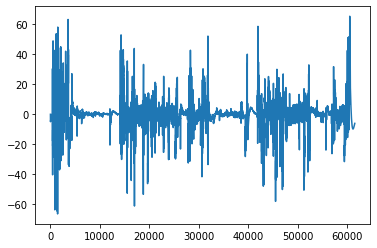

In [46]:
plt.plot(round_signal1)
plt.show()

In [47]:
#round_signal_new1 = np.round(round_signal1/10)*10
#round_signal_new2 = np.round(round_signal2/10)*10
#round_signal_new3 = np.round(round_signal3/10)*10

In [48]:
#np.savetxt('acc_signal_rounded1.txt',round_signal_new1,fmt='%.1f')
#np.savetxt('acc_signal_rounded2.txt',round_signal_new2,fmt='%.1f')
#np.savetxt('acc_signal_rounded3.txt',round_signal_new3,fmt='%.1f')

In [49]:
np.savetxt('acc_signal_rounded1.txt',round_signal1,fmt='%.2f')
np.savetxt('acc_signal_rounded2.txt',round_signal2,fmt='%.2f')
np.savetxt('acc_signal_rounded3.txt',round_signal3,fmt='%.2f')

In [50]:
decoded_data_c1 = np.loadtxt(fname = "acc_signal_rounded1.txt")
decoded_data_c2 = np.loadtxt(fname = "acc_signal_rounded2.txt")
decoded_data_c3 = np.loadtxt(fname = "acc_signal_rounded3.txt")

Use Huffman coding to encode this normalized signal sequence.

Before Huffman coding, the size of the txt file of this signal sequence is 1238kB. After Huffman coding, the size of the txt file of this signal sequence is 522kB.

The original size of the raw data is 708kB in csv and 5.6MB in txt. If we calculate the compression ratio by the same data format. The compression ratio is 10.99


#### PRD calculation:


In [51]:
#resampled_signal_ori = signal.resample(ECG_array, 564001)

In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD1 = PRD_calculation(resampled_signal1, decoded_data_c1)
print("The PRD1 is {}%".format(round(PRD1*100,3)))
PRD2 = PRD_calculation(resampled_signal2, decoded_data_c2)
print("The PRD2 is {}%".format(round(PRD2*100,3)))
PRD3 = PRD_calculation(resampled_signal3, decoded_data_c3)
print("The PRD3 is {}%".format(round(PRD3*100,3)))

The PRD1 is 0.031%
The PRD2 is 0.02%
The PRD3 is 0.021%


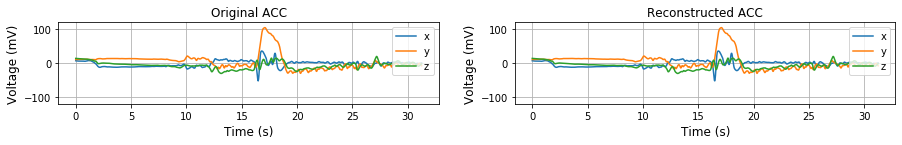

In [72]:
time_index = np.linspace(0,31.25,1000)
fig, ax = plt.subplots(1,2, figsize = (15,1.5))

ax[0].plot(time_index, resampled_signal1[15000:16000], label = "x")
ax[0].plot(time_index, resampled_signal2[15000:16000], label = "y")
ax[0].plot(time_index, resampled_signal3[15000:16000], label = "z")
ax[0].grid()
ax[0].legend(loc = 'upper right')
ax[0].set_title("Original ACC")
ax[0].set_xlabel("Time (s)", size = 12)
ax[0].set_ylabel("Voltage (mV)", size = 12)
ax[0].set_ylim(-120,120)


ax[1].plot(time_index, decoded_data_c1[15000:16000], label = "x")
ax[1].plot(time_index, decoded_data_c2[15000:16000], label = "y")
ax[1].plot(time_index, decoded_data_c3[15000:16000], label = "z")
ax[1].grid()
ax[1].legend(loc = 'upper right')
ax[1].set_title("Reconstructed ACC")
ax[1].set_xlabel("Time (s)", size = 12)
ax[1].set_ylabel("Voltage (mV)", size = 12)
ax[1].set_ylim(-120,120)
plt.savefig('acc_huffman.png',dpi=100)

### Instructions

Put instructions of how to use your method here.

More instruction needs to be well documented

Dependencies: 

All codes based on Python3
Numpy, Pandas, tcmpr 0.2 installed on the users' system

### Evaluation

The results of this method on the following wearable sensors:

| Wearable Sensor | Compression Ratio | Percentage RMS difference |
| ------ | ------ | ------ | 
| ECG | 17 | 0.949% |
| PPG | XX | XX |
| ACC | XX | XX |
| EDA | XX | XX |
| TEMP | XX | XX |